# TASK 3 - Clustering and Phylogeny
Zofia Łągiewka 

In [189]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import pandas as pd
import numpy as np
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
from Bio.Phylo.Consensus import majority_consensus
from matplotlib.gridspec import GridSpec
from math import ceil
from sklearn.metrics import silhouette_score

## Data preprocessing

In [190]:
file_path = 'data/db/output_results.txt' 
columns = ["Query ID", "Subject ID", "Percent Identity", "Alignment Length", "Mismatches", "Gap Opens", "Query Start", "Query End", "Subject Start", "Subject End", "E-value", "Bit Score"]

In [191]:
blast_df = pd.read_csv(file_path, sep="\t", names=columns)
print(blast_df.head())

                      Query ID                        Subject ID  \
0  albumin_Chlorocebus_sabaeus       albumin_Chlorocebus_sabaeus   
1  albumin_Chlorocebus_sabaeus       albumin_Macaca_fascicularis   
2  albumin_Chlorocebus_sabaeus            albumin_Macaca_mulatta   
3  albumin_Chlorocebus_sabaeus              albumin_Papio_anubis   
4  albumin_Chlorocebus_sabaeus  albumin_Trachypithecus_francoisi   

   Percent Identity  Alignment Length  Mismatches  Gap Opens  Query Start  \
0           100.000               608           0          0            1   
1            99.013               608           6          0            1   
2            98.849               608           7          0            1   
3            98.520               608           9          0            1   
4            95.888               608          25          0            1   

   Query End  Subject Start  Subject End  E-value  Bit Score  
0        608              1          608      0.0     1236.0  
1 

In [192]:
sequence_ids = blast_df['Query ID'].unique()
similarity_matrix = pd.DataFrame(np.zeros((len(sequence_ids), len(sequence_ids))), index=sequence_ids, columns=sequence_ids, dtype=float)

In [193]:
for _, row in blast_df.iterrows():
    query = row["Query ID"]
    subject = row["Subject ID"]
    identity = row["Percent Identity"]
    similarity_matrix.loc[query, subject] = identity

## 1. Clustering

In [194]:
distance_matrix = 1 - (similarity_matrix / 100)

### Hierarchical clustering

In [195]:
linkage_matrix = linkage(distance_matrix, method='average')

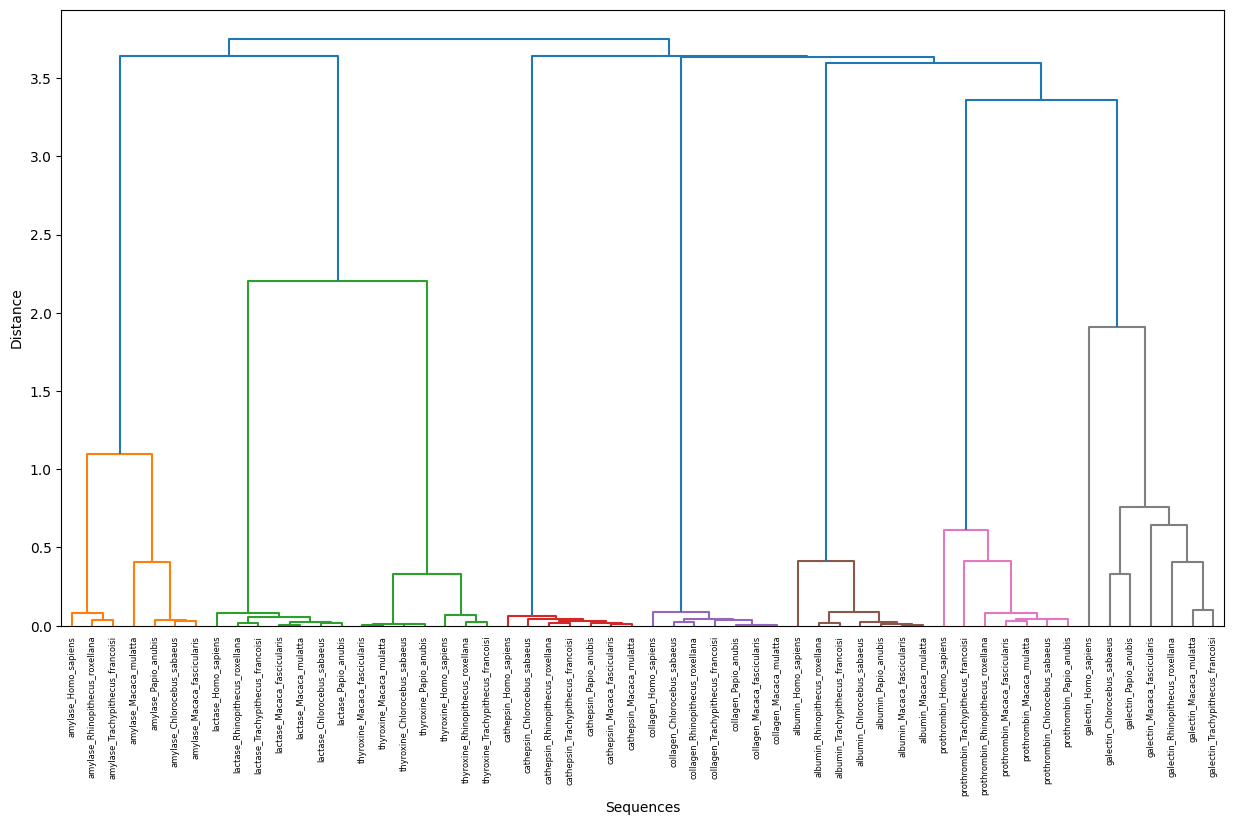

In [196]:
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=distance_matrix.index, leaf_rotation=90)
plt.xlabel("Sequences")
plt.ylabel("Distance")
plt.show()

### KMeans clustering

In [197]:
kmeans = KMeans()
clusters = kmeans.fit_predict(distance_matrix)
cluster_df = pd.DataFrame({'Sequence': distance_matrix.index, 'Cluster': clusters}).sort_values(by='Cluster')

In [198]:
for cluster in cluster_df['Cluster'].unique():
    print(f"Cluster {cluster + 1}:")
    print(cluster_df[cluster_df['Cluster'] == cluster]['Sequence'].to_list())
    print()

Cluster 1:
['collagen_Homo_sapiens', 'collagen_Trachypithecus_francoisi', 'collagen_Rhinopithecus_roxellana', 'collagen_Papio_anubis', 'collagen_Macaca_mulatta', 'collagen_Macaca_fascicularis', 'collagen_Chlorocebus_sabaeus']

Cluster 2:
['thyroxine_Rhinopithecus_roxellana', 'thyroxine_Papio_anubis', 'thyroxine_Macaca_mulatta', 'thyroxine_Macaca_fascicularis', 'thyroxine_Chlorocebus_sabaeus', 'thyroxine_Trachypithecus_francoisi', 'thyroxine_Homo_sapiens']

Cluster 3:
['galectin_Homo_sapiens', 'galectin_Trachypithecus_francoisi', 'galectin_Rhinopithecus_roxellana', 'galectin_Papio_anubis', 'galectin_Macaca_mulatta', 'galectin_Macaca_fascicularis', 'galectin_Chlorocebus_sabaeus']

Cluster 4:
['cathepsin_Chlorocebus_sabaeus', 'cathepsin_Papio_anubis', 'cathepsin_Macaca_fascicularis', 'cathepsin_Macaca_mulatta', 'cathepsin_Rhinopithecus_roxellana', 'cathepsin_Trachypithecus_francoisi', 'cathepsin_Homo_sapiens']

Cluster 5:
['albumin_Trachypithecus_francoisi', 'albumin_Chlorocebus_sabaeus',

In [199]:
silhouette_avg = silhouette_score(distance_matrix, clusters)
print(f"Silhouette Score for k=8: {silhouette_avg:.2f}")

db_score = davies_bouldin_score(distance_matrix, clusters)
print(f"Davies-Bouldin Index for k=8: {db_score:.2f}")

Silhouette Score for k=8: 0.90
Davies-Bouldin Index for k=8: 0.25


## 2. Trees

In [200]:
def convert_to_lower(m):
    names = m.index.tolist()
    lower_triangular = []
    for i in range(len(m)):
        lower_triangular.append(m.values[i, :i + 1].tolist())
    return lower_triangular, names

In [201]:
def build_and_plot_tree(matrix, labels):
    m = DistanceMatrix(names=labels, matrix=matrix)
    const = DistanceTreeConstructor()
    tree = const.upgma(m)
    
    Phylo.draw(tree, label_func=lambda x: x.name if x.is_terminal() else None)

### Separate tree for each "group" of proteins

In [202]:
blast_df['Protein'] = blast_df['Query ID'].str.split('_').str[0]
protein_groups = blast_df['Protein'].unique()

num_groups = len(protein_groups)
num_columns = 2
num_rows = ceil(num_groups / num_columns)


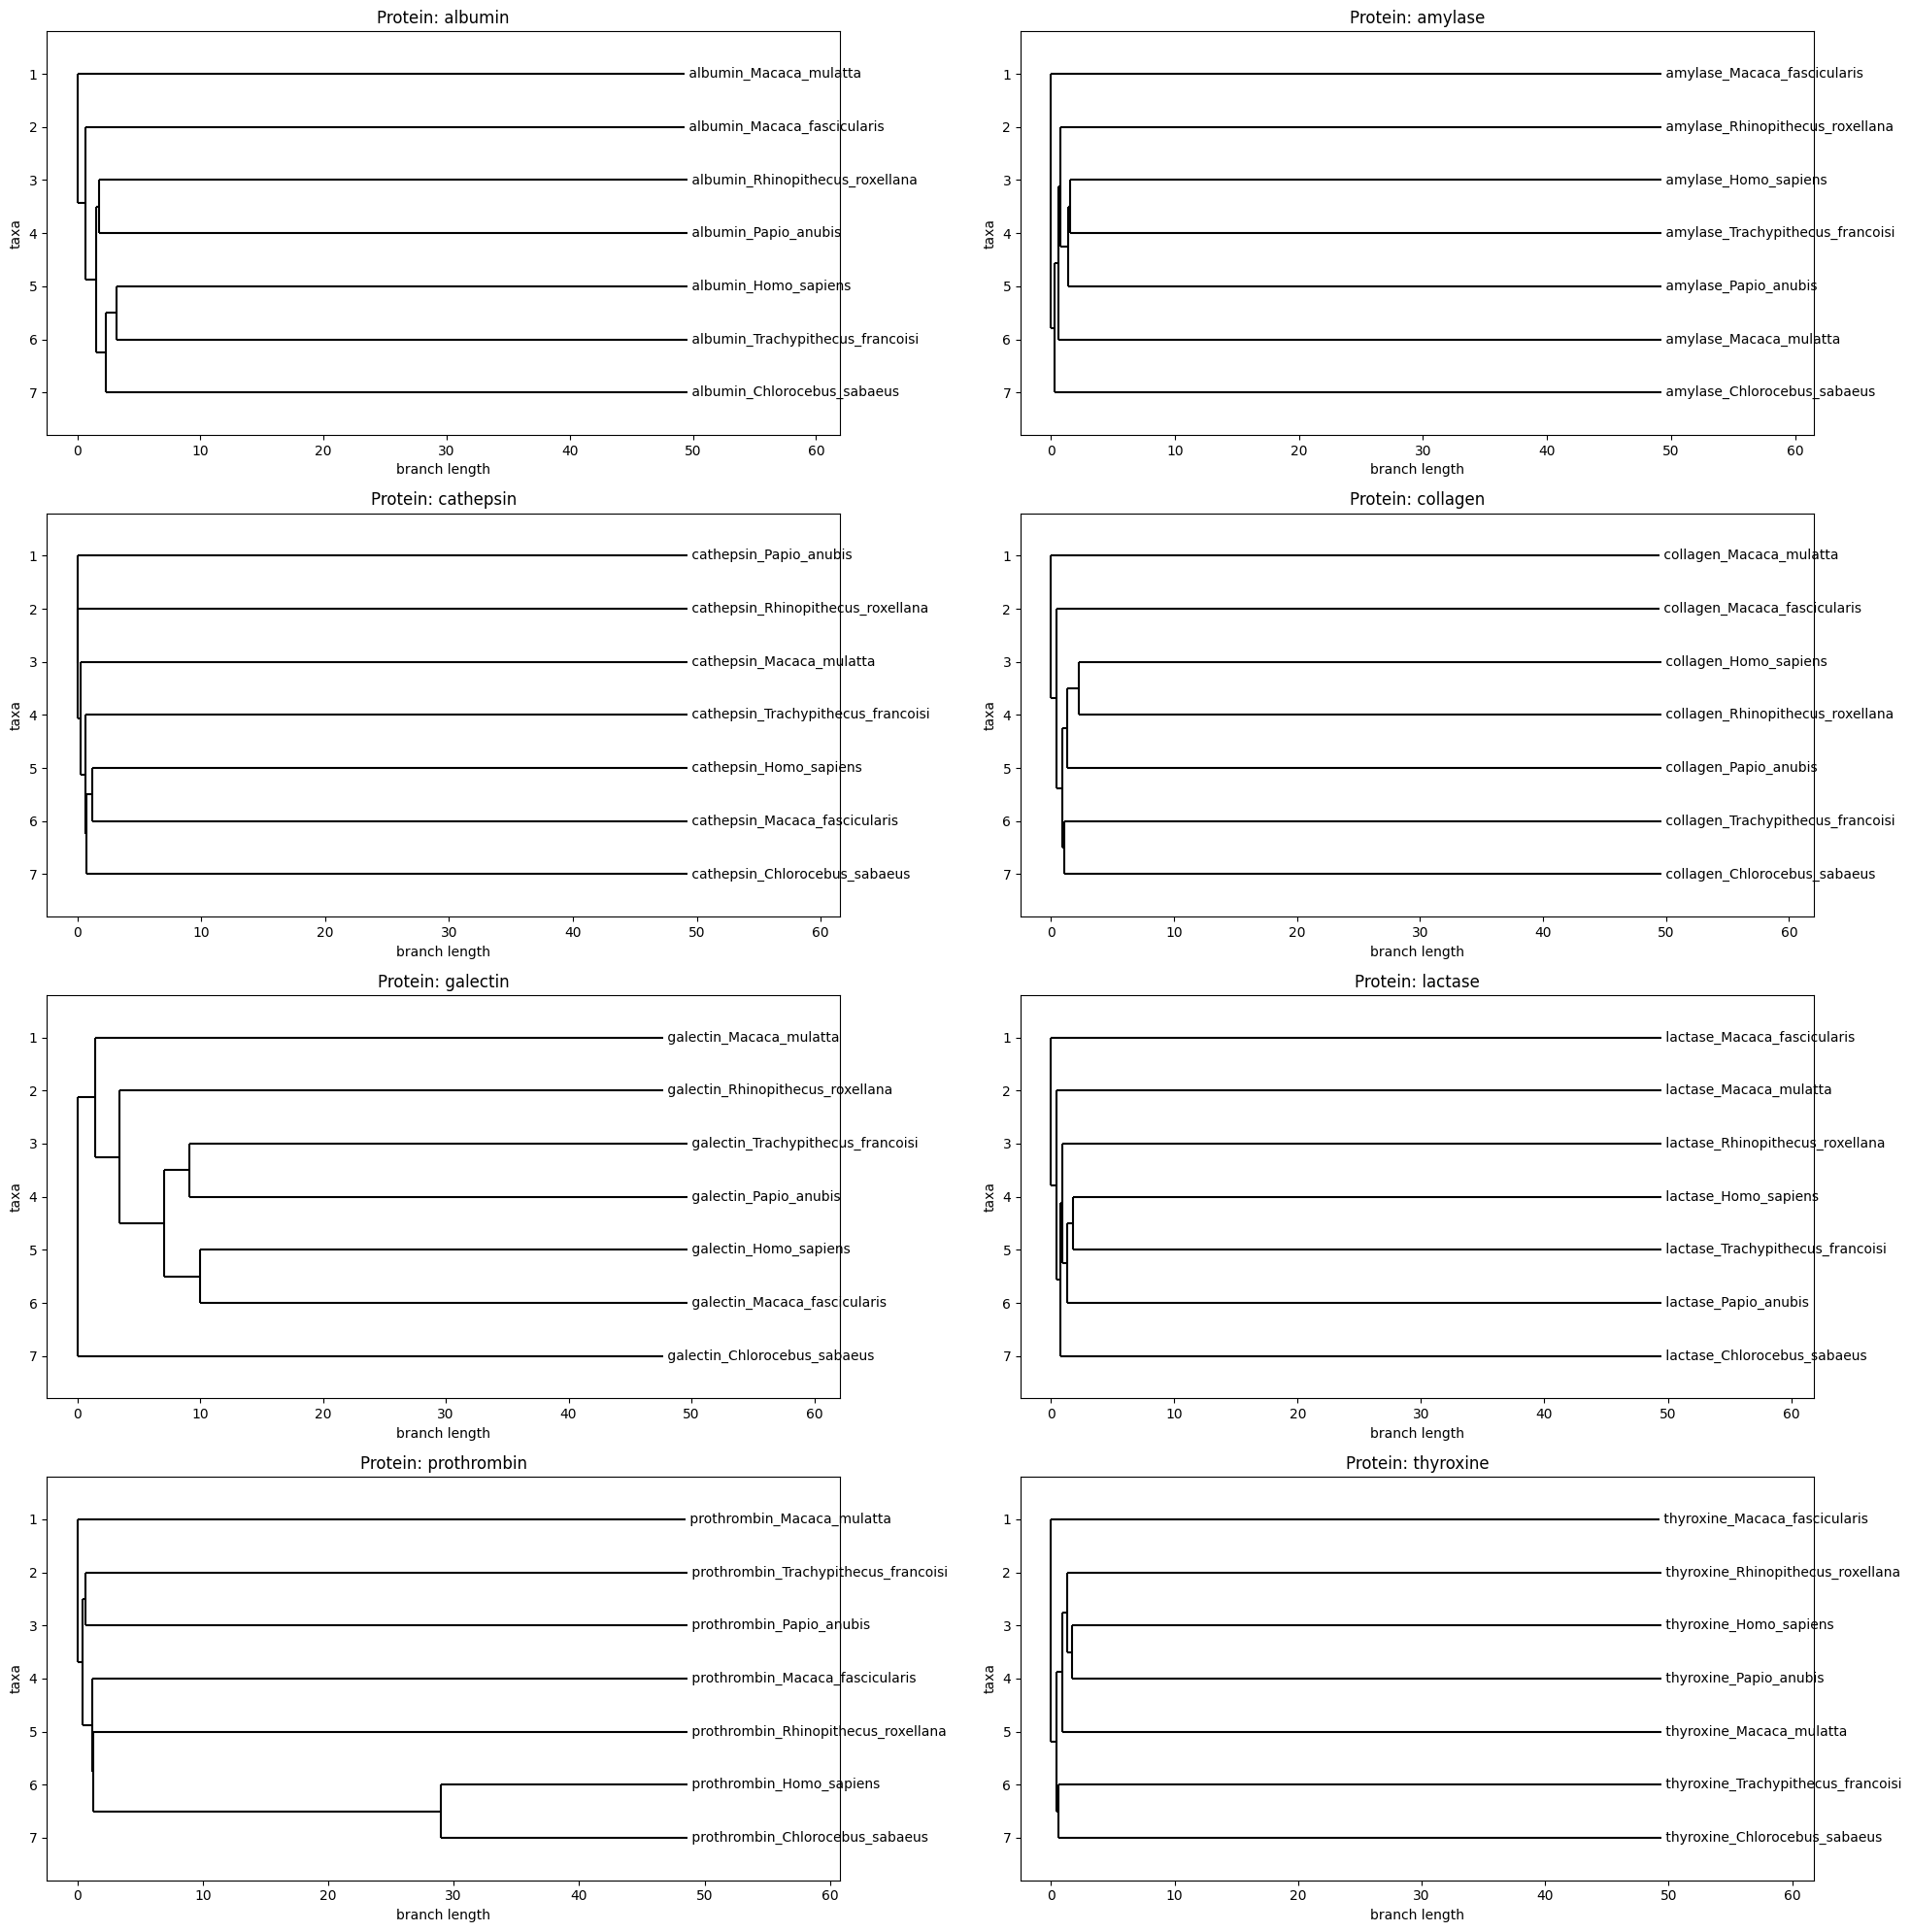

In [203]:
fig = plt.figure(figsize=(20, num_rows * 5))
gs = GridSpec(num_rows, num_columns, figure=fig)

group_trees = {}
for idx, group in enumerate(protein_groups):
    group_sequences = blast_df[blast_df['Protein'] == group]['Query ID'].unique()
    group_matrix = similarity_matrix.loc[group_sequences, group_sequences]

    matrix, labels = convert_to_lower(group_matrix)

    bio_distance_matrix = DistanceMatrix(names=labels, matrix=matrix)
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(bio_distance_matrix)
    group_trees[group] = tree

    ax = fig.add_subplot(gs[idx // num_columns, idx % num_columns])
    Phylo.draw(tree, axes=ax, do_show=False, label_func=lambda x: x.name if x.is_terminal() else None)
    ax.set_title(f"Protein: {group}")

plt.tight_layout()

### Separate tree for each cluster

In [204]:
num_clusters = len(cluster_df['Cluster'].unique())
num_columns = 2
num_rows = ceil(num_clusters / num_columns)

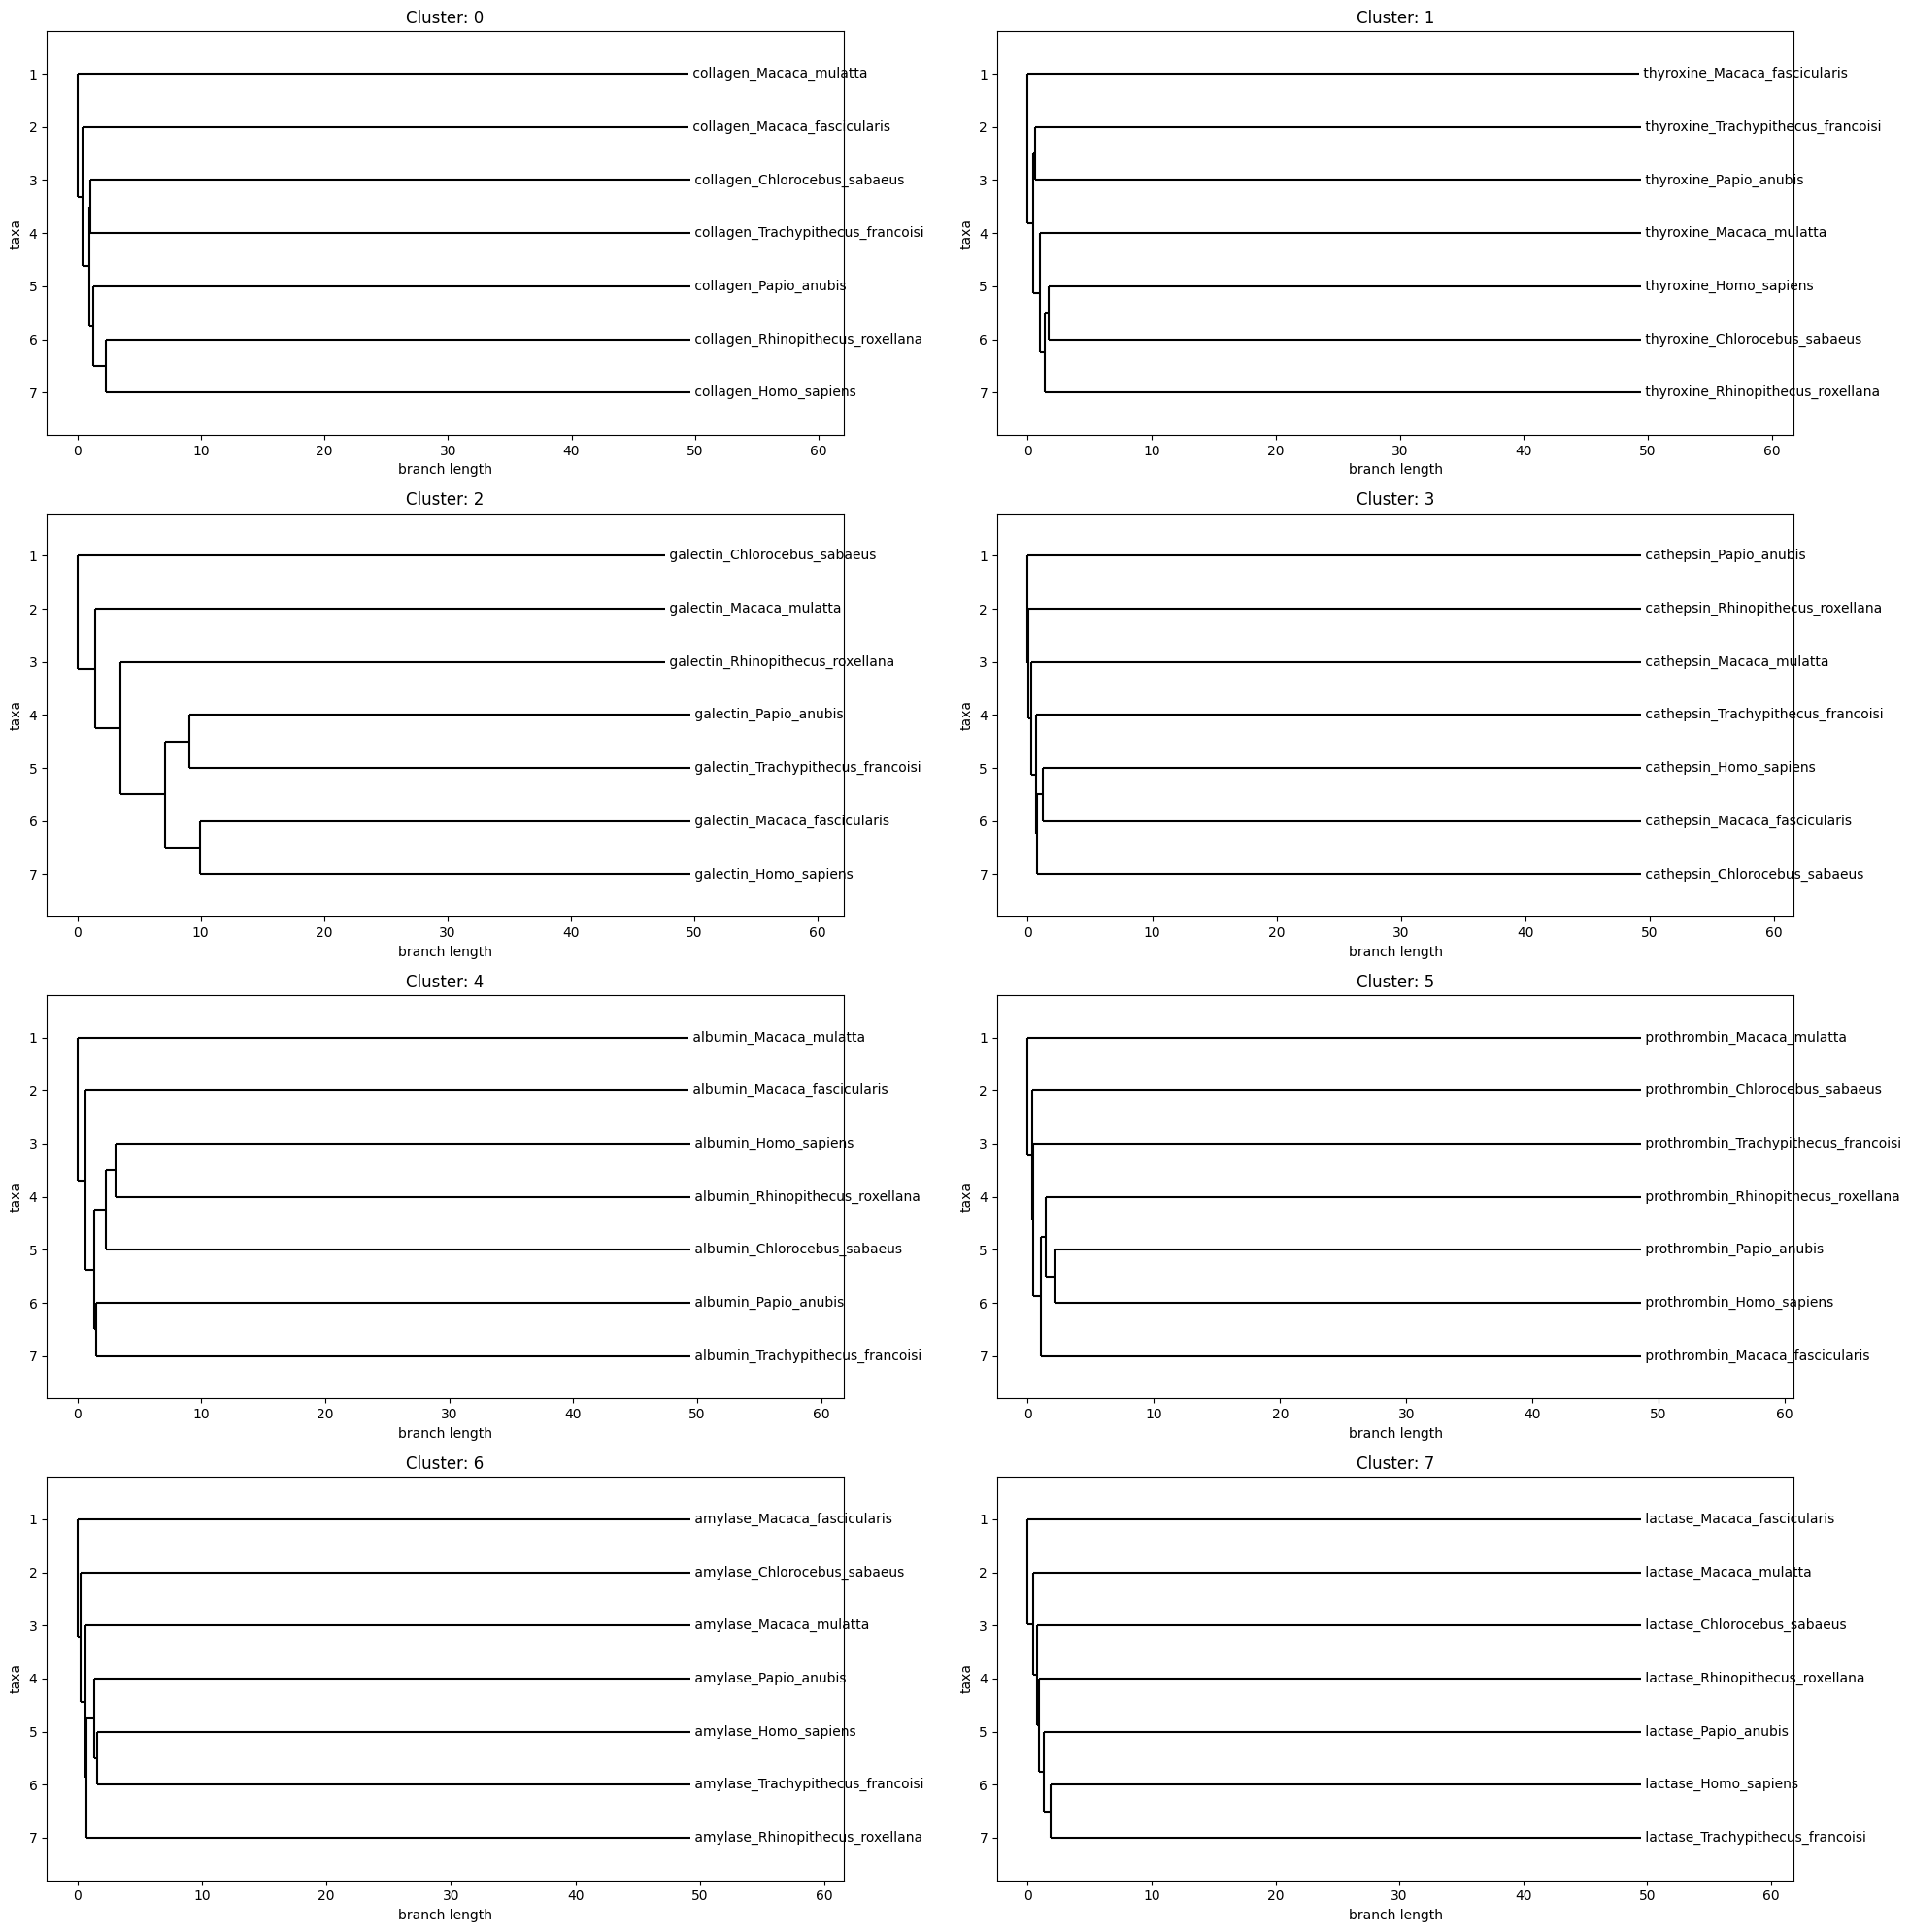

In [205]:
fig = plt.figure(figsize=(20, num_rows * 5))
gs = GridSpec(num_rows, num_columns, figure=fig)  

cluster_trees = {}
for idx, cluster in enumerate(cluster_df['Cluster'].unique()):

    cluster_elements = cluster_df[cluster_df['Cluster'] == cluster]['Sequence']
    cluster_matrix = similarity_matrix.loc[cluster_elements, cluster_elements]
    matrix, labels = convert_to_lower(cluster_matrix)

    bio_distance_matrix = DistanceMatrix(names=labels, matrix=matrix)
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(bio_distance_matrix)
    cluster_trees[cluster] = tree 

    ax = fig.add_subplot(gs[idx // num_columns, idx % num_columns])

    Phylo.draw(tree, axes=ax, do_show=False, label_func=lambda x: x.name if x.is_terminal() else None)
    ax.set_title(f"Cluster: {cluster}")

plt.tight_layout()

### One common tree for all downloaded sequences

In [206]:
matrix_all, labels_all = convert_to_lower(distance_matrix)
bio_distance_matrix = DistanceMatrix(names=labels_all, matrix=matrix_all)

constructor = DistanceTreeConstructor()
combined_tree = constructor.upgma(bio_distance_matrix)

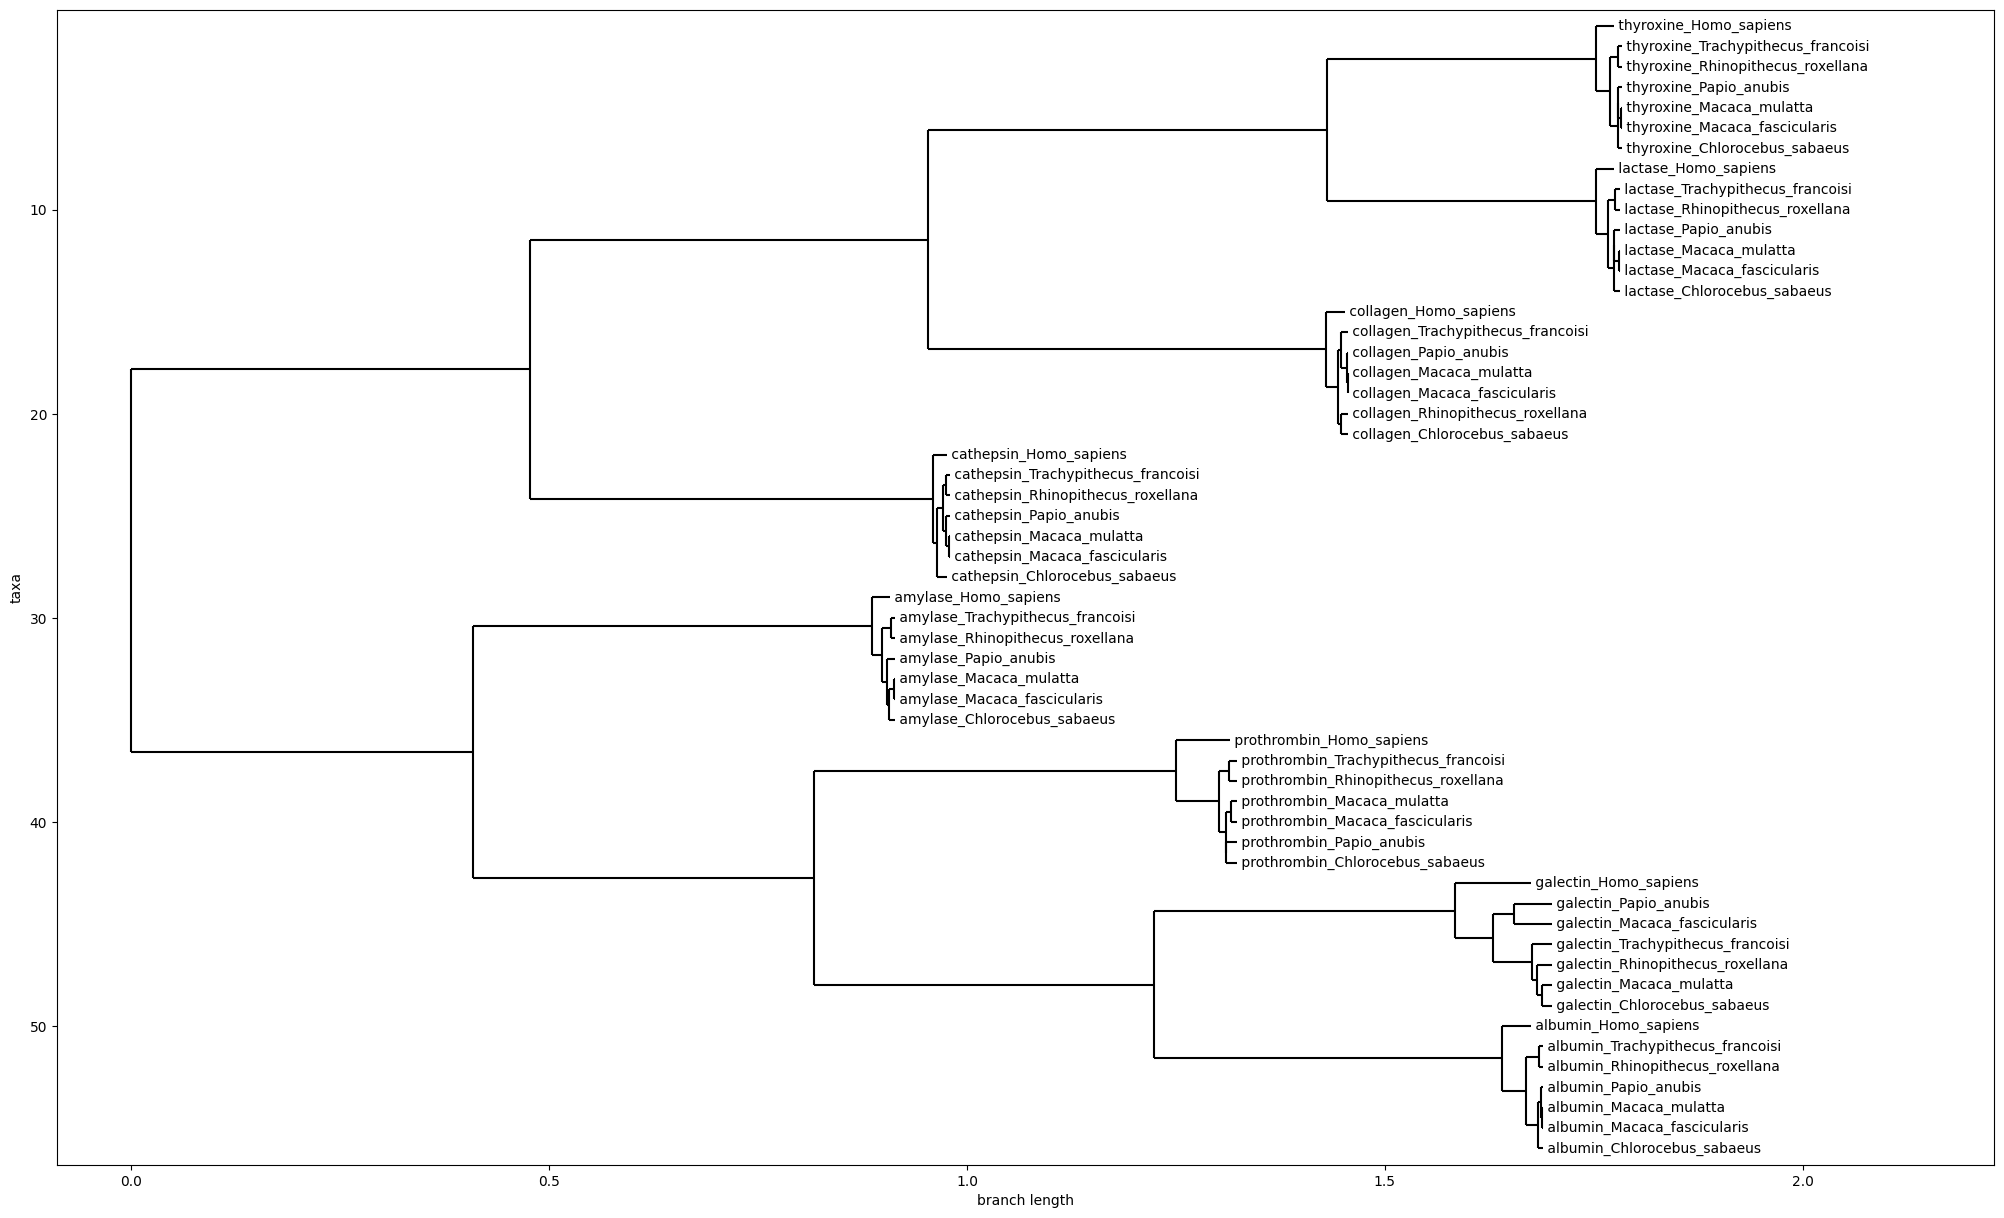

In [207]:
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(combined_tree, axes=ax, do_show=False, label_func=lambda x: x.name if x.is_terminal() else None)

## Consensus trees

In [208]:
def preprocess_tree_labels(tree):
    for clade in tree.get_terminals():       
        parts = clade.name.split('_', 1)  
        clade.name = parts[1].replace('_', ' ') if len(parts) > 1 else None

In [209]:
for key, tree in group_trees.items():
    preprocess_tree_labels(tree)

for key, tree in cluster_trees.items():
    preprocess_tree_labels(tree)

#### Proteins

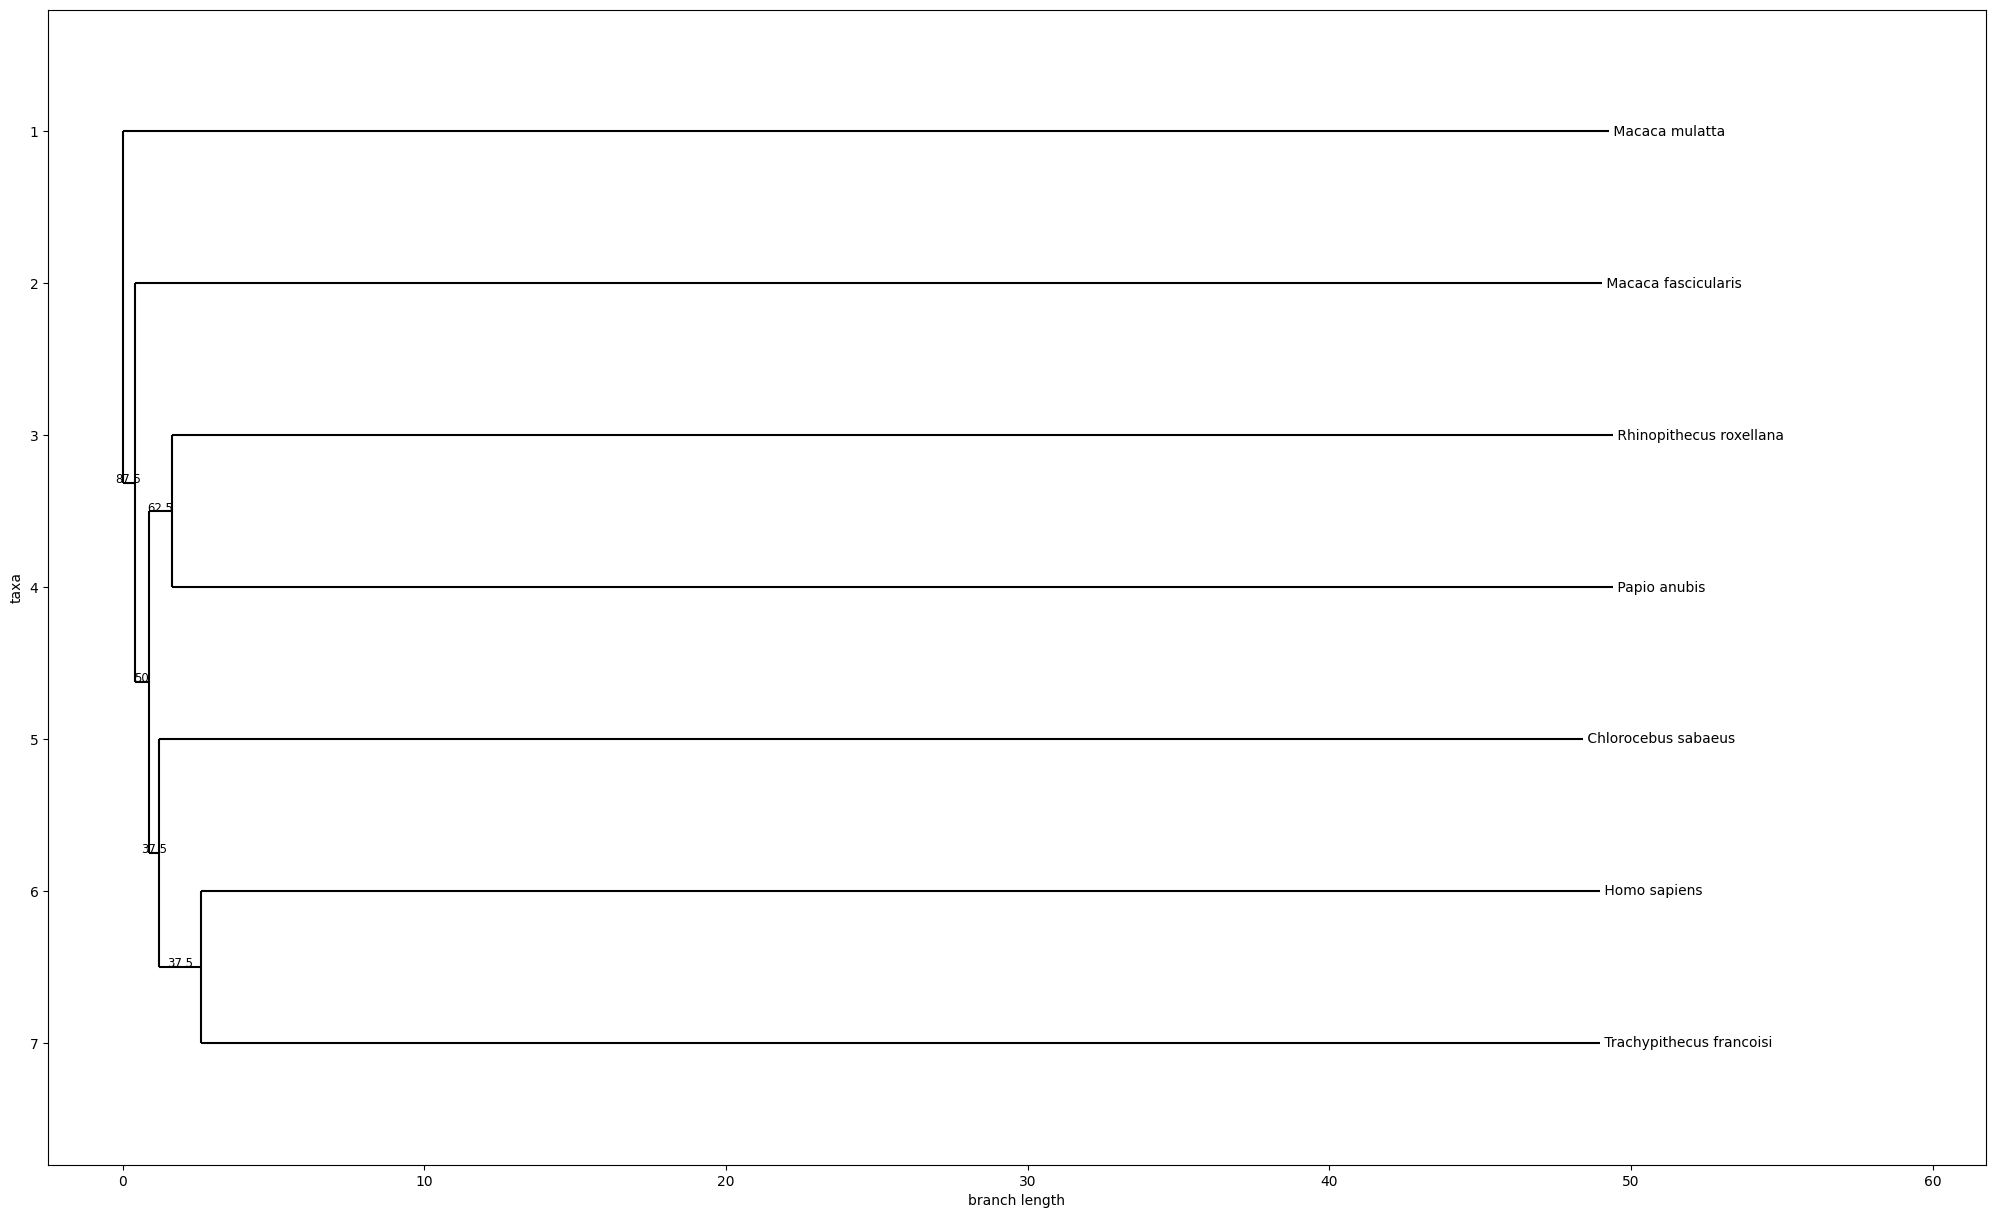

In [210]:
consensus_tree_proteins = majority_consensus(list(group_trees.values()))

fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(consensus_tree_proteins, axes=ax, label_func=lambda x: x.name if x.is_terminal() else None)

#### Clusters

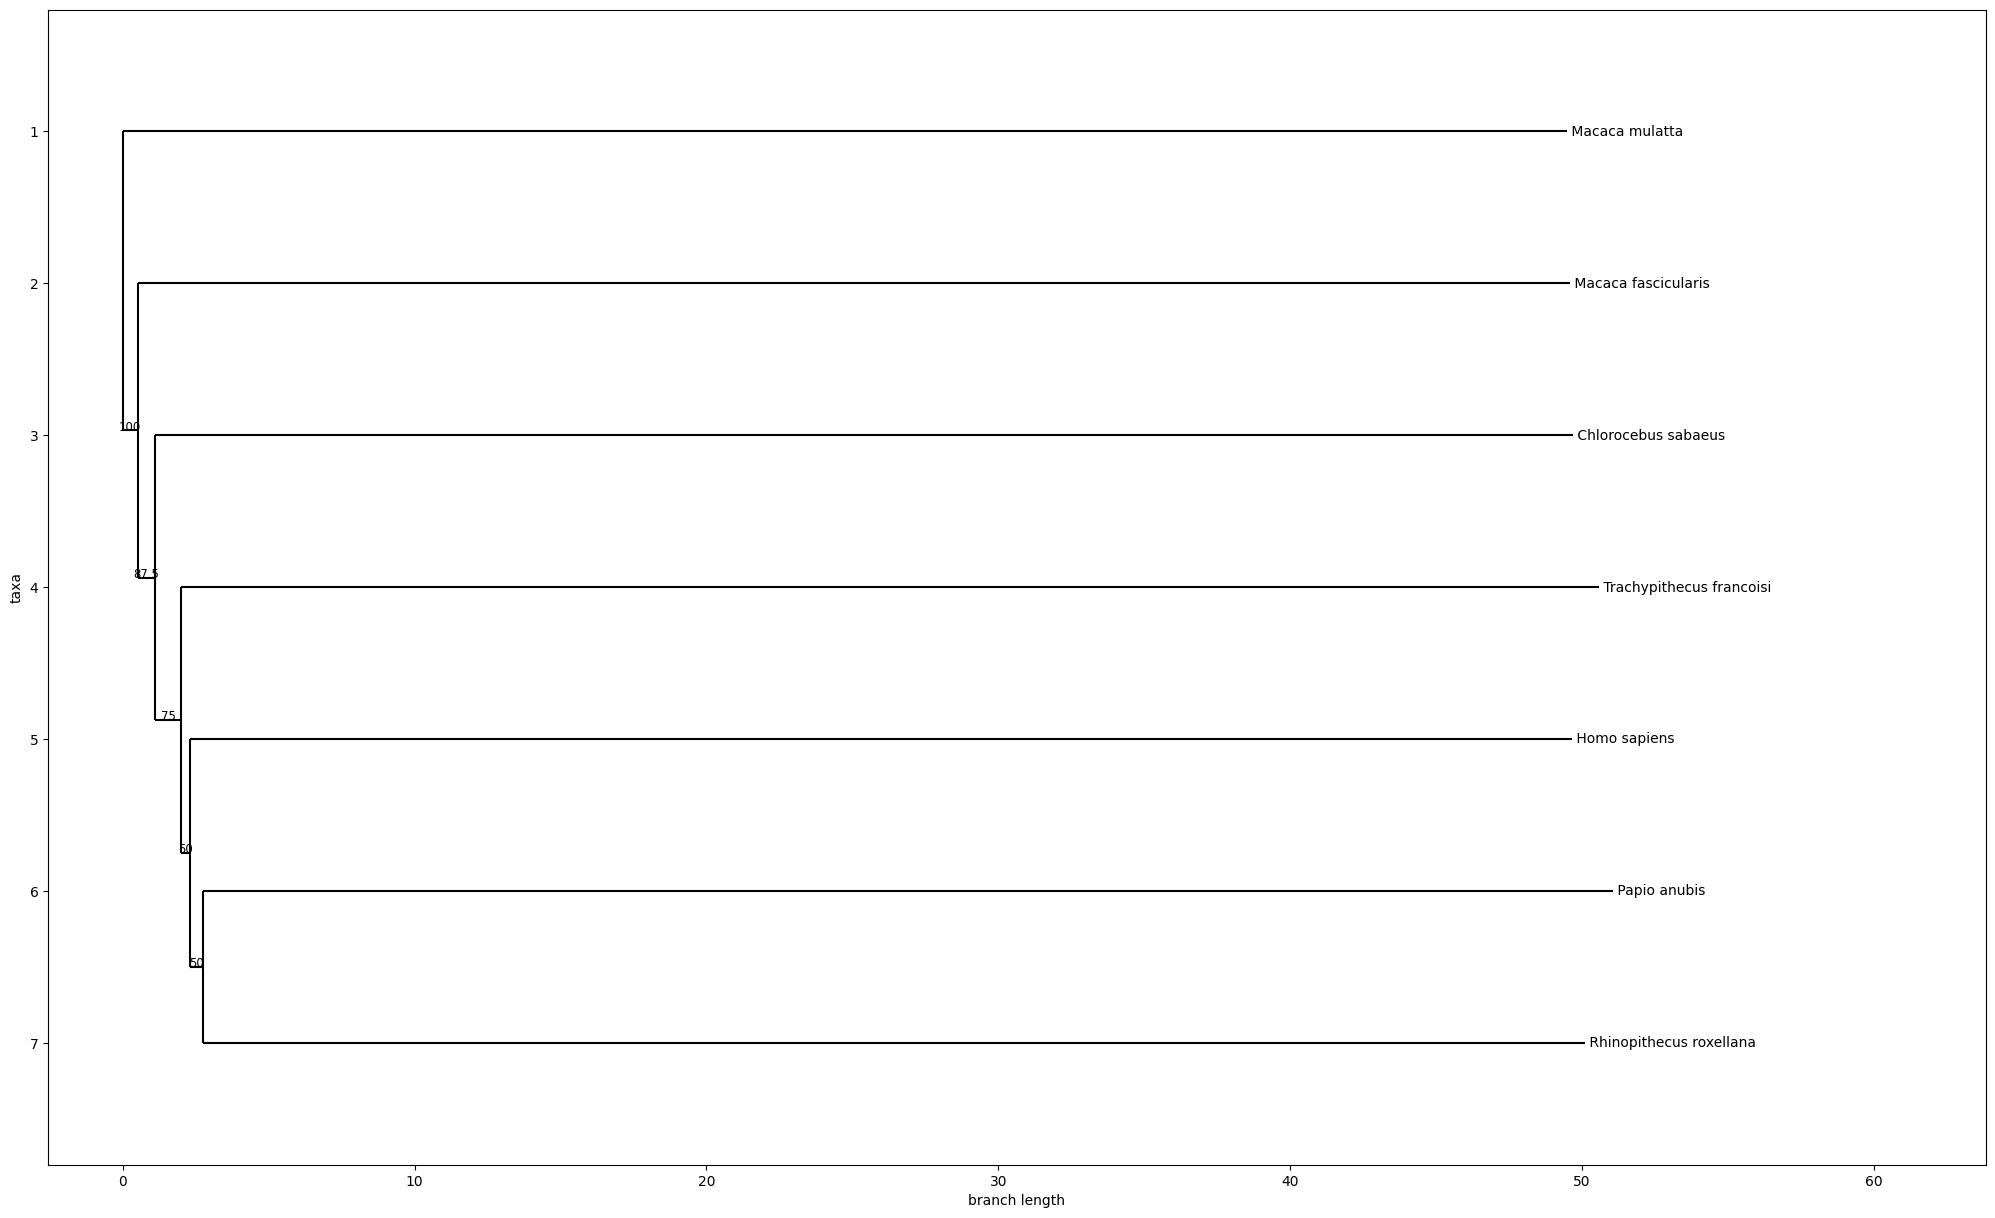

In [211]:
consensus_tree_clusters = majority_consensus(list(cluster_trees.values()))

fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(consensus_tree_clusters, axes=ax, label_func=lambda x: x.name if x.is_terminal() else None)

## Coloring the tree

In [212]:
organism_colors = {
    'Macaca mulatta': 'green',
    'Rhinopithecus roxellana': 'red',
    'Chlorocebus sabaeus': '#00BFFF',
    'Homo sapiens': 'orange',
    'Trachypithecus francoisi': 'navy',
    'Papio anubis': '#FF1493',
    'Macaca fascicularis': 'purple'
}

protein_colors = {
    'cathepsin': 'green',
    'prothrombin': 'red',
    'thyroxine': 'orange',
    'galectin': 'purple',
    'lactase': 'navy',
    'albumin': 'teal',
    'collagen': '#00BFFF',
    'amylase': '#FF1493'
}

In [213]:
def label_extractor(name):
    parts = name.split('_', 1)  
    organism = parts[0].replace('_', ' ') 
    protein = parts[1].replace('_', ' ') if len(parts) > 1 else None  
    return organism, protein

In [214]:
def color_tree(tree, color_mapping, org=True):
    label_colors = {}
    for clade in tree.find_clades():
        if clade.name:
            protein, organism = label_extractor(clade.name)
            label = organism if org else protein
            if label in color_mapping:
                clade.color = color_mapping[label]  
                label_colors[clade.name] = color_mapping[label]  
            else:
                clade.color = 'black' 
    return label_colors

In [215]:
def color_tree_consensus(tree, color_mapping):
    label_colors = {}
    for clade in tree.find_clades():
        if clade.name  in color_mapping:
            clade.color = color_mapping[clade.name]  
            label_colors[clade.name] = color_mapping[clade.name]  
        else:
            clade.color = 'black' 
    return label_colors

### Consensus tree

In [216]:
label_colors = color_tree_consensus(consensus_tree_proteins, organism_colors)

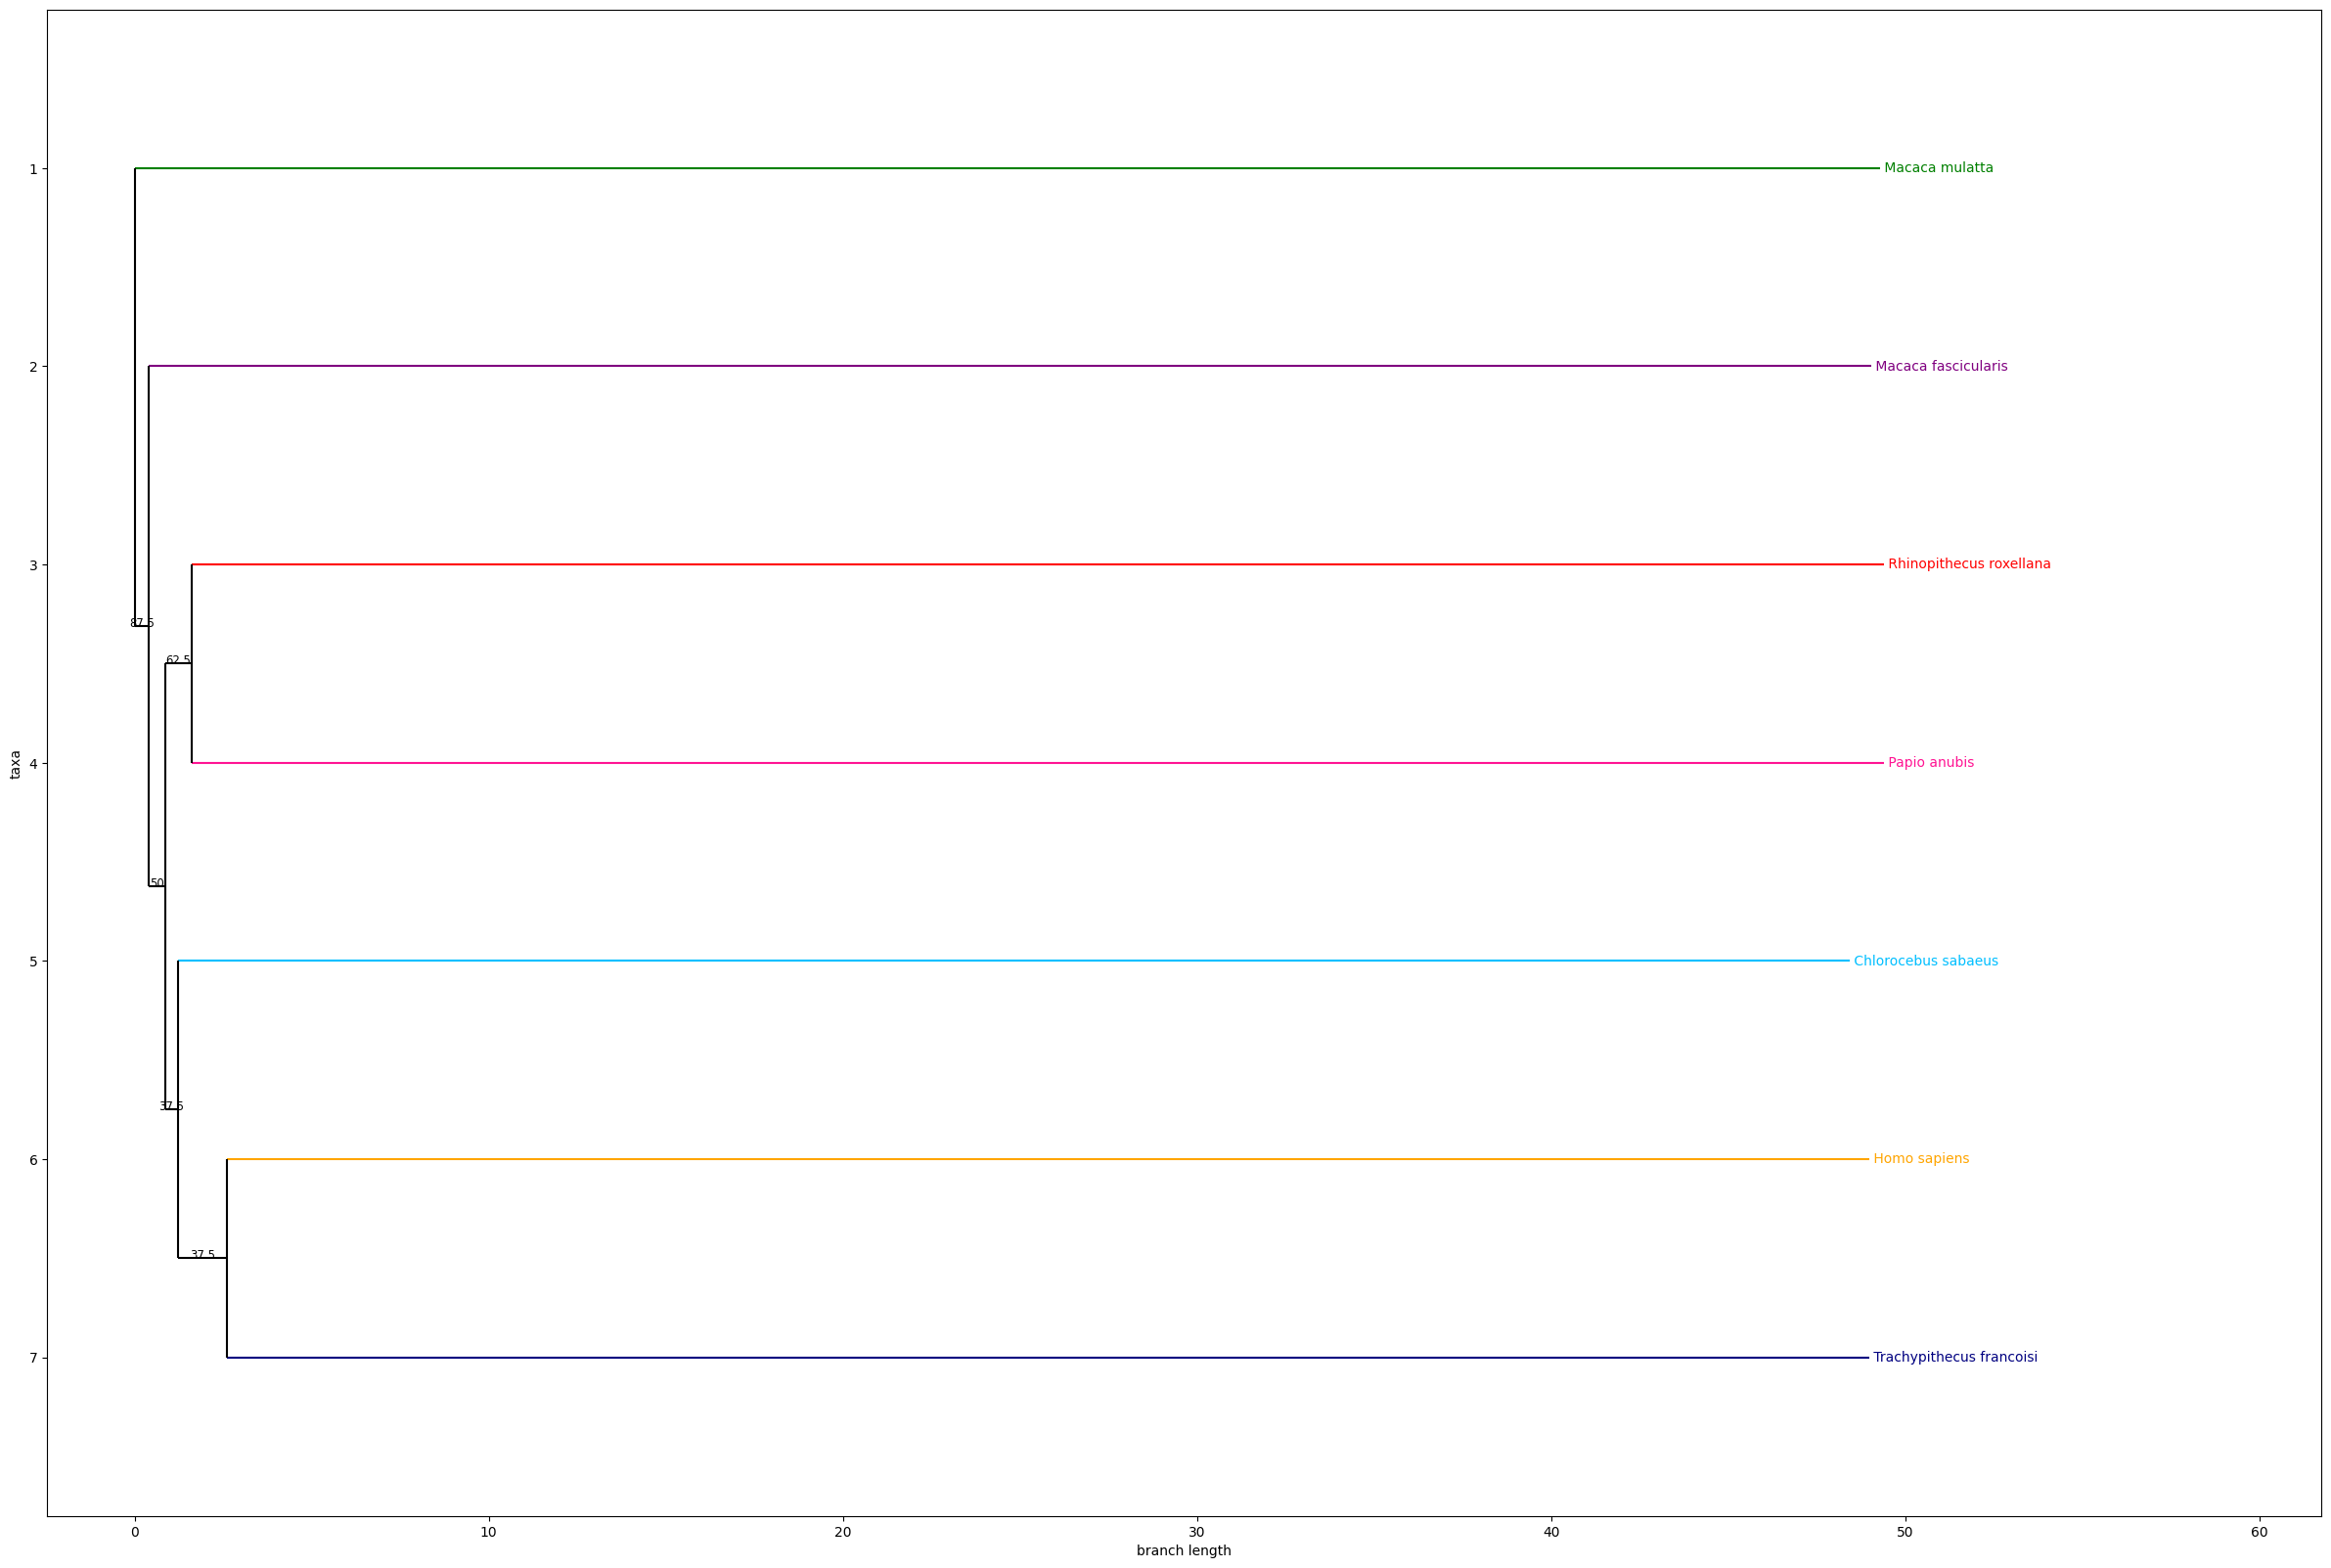

In [217]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(consensus_tree_proteins, axes=ax, label_func=lambda x: x.name if x.is_terminal() else None, label_colors=label_colors)

In [218]:
label_colors = color_tree_consensus(consensus_tree_clusters, organism_colors)

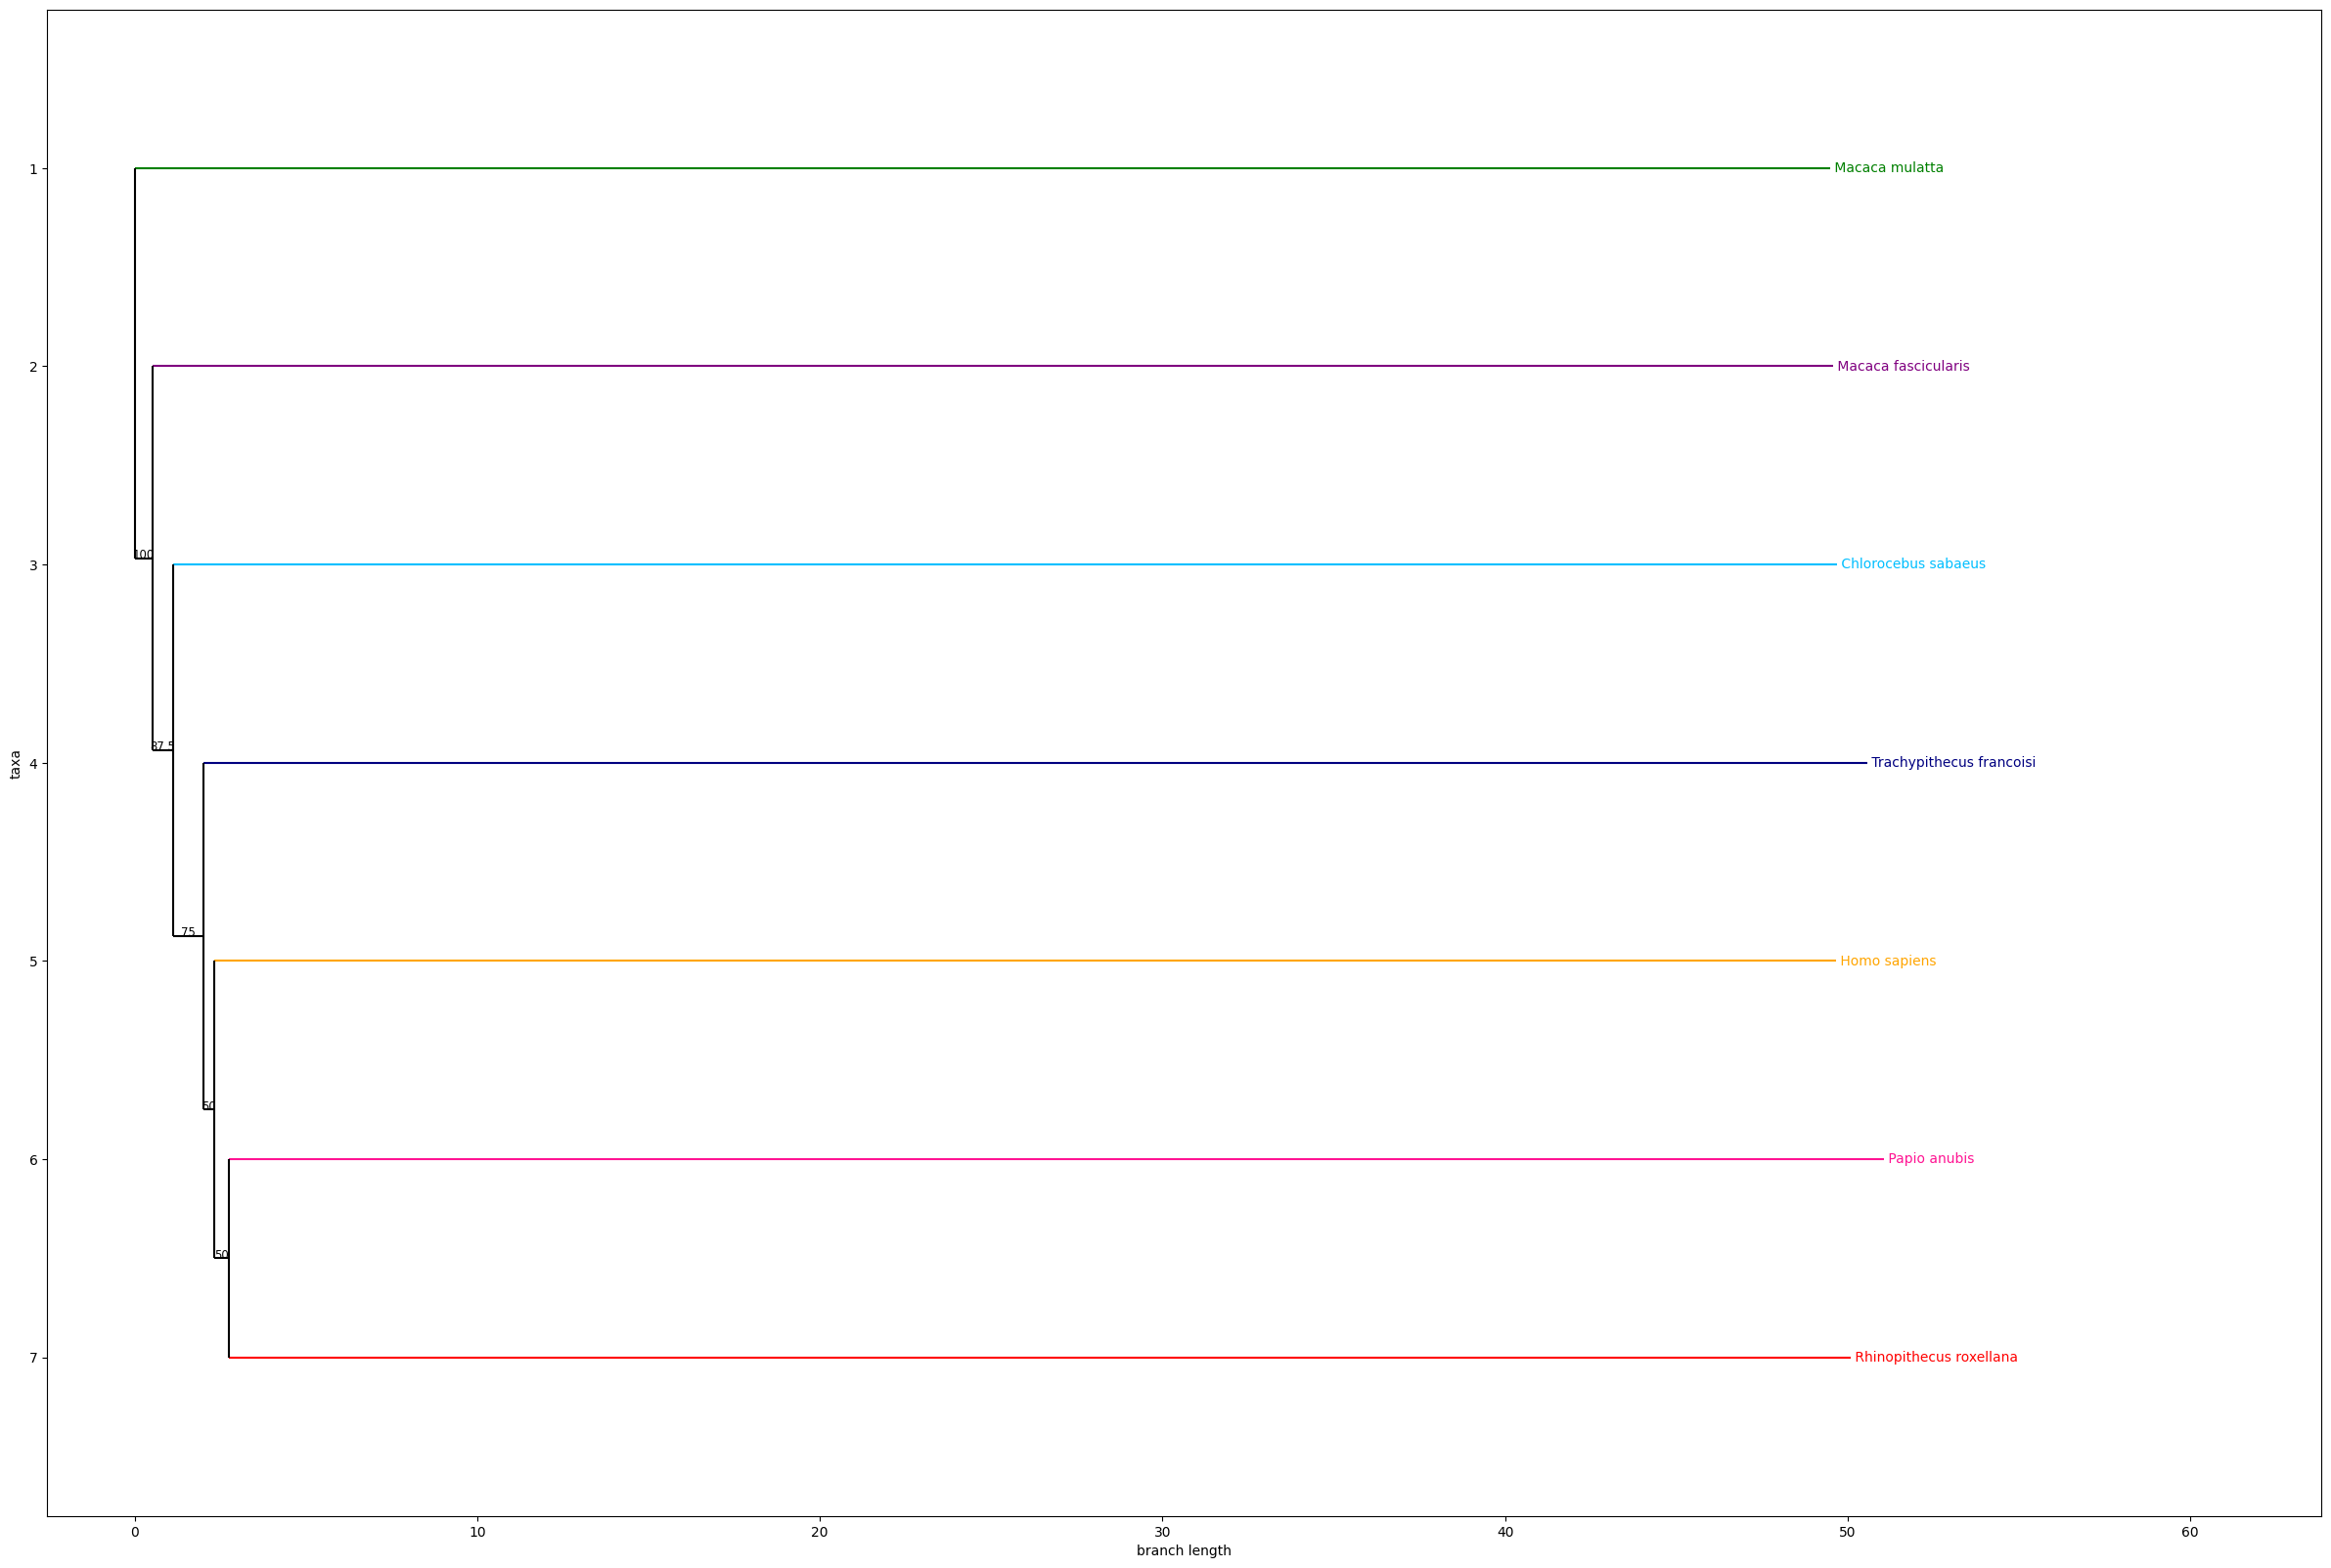

In [219]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(consensus_tree_clusters, axes=ax, label_func=lambda x: x.name if x.is_terminal() else None, label_colors=label_colors)

### Common tree - organisms

In [220]:
label_colors = color_tree(combined_tree, organism_colors)

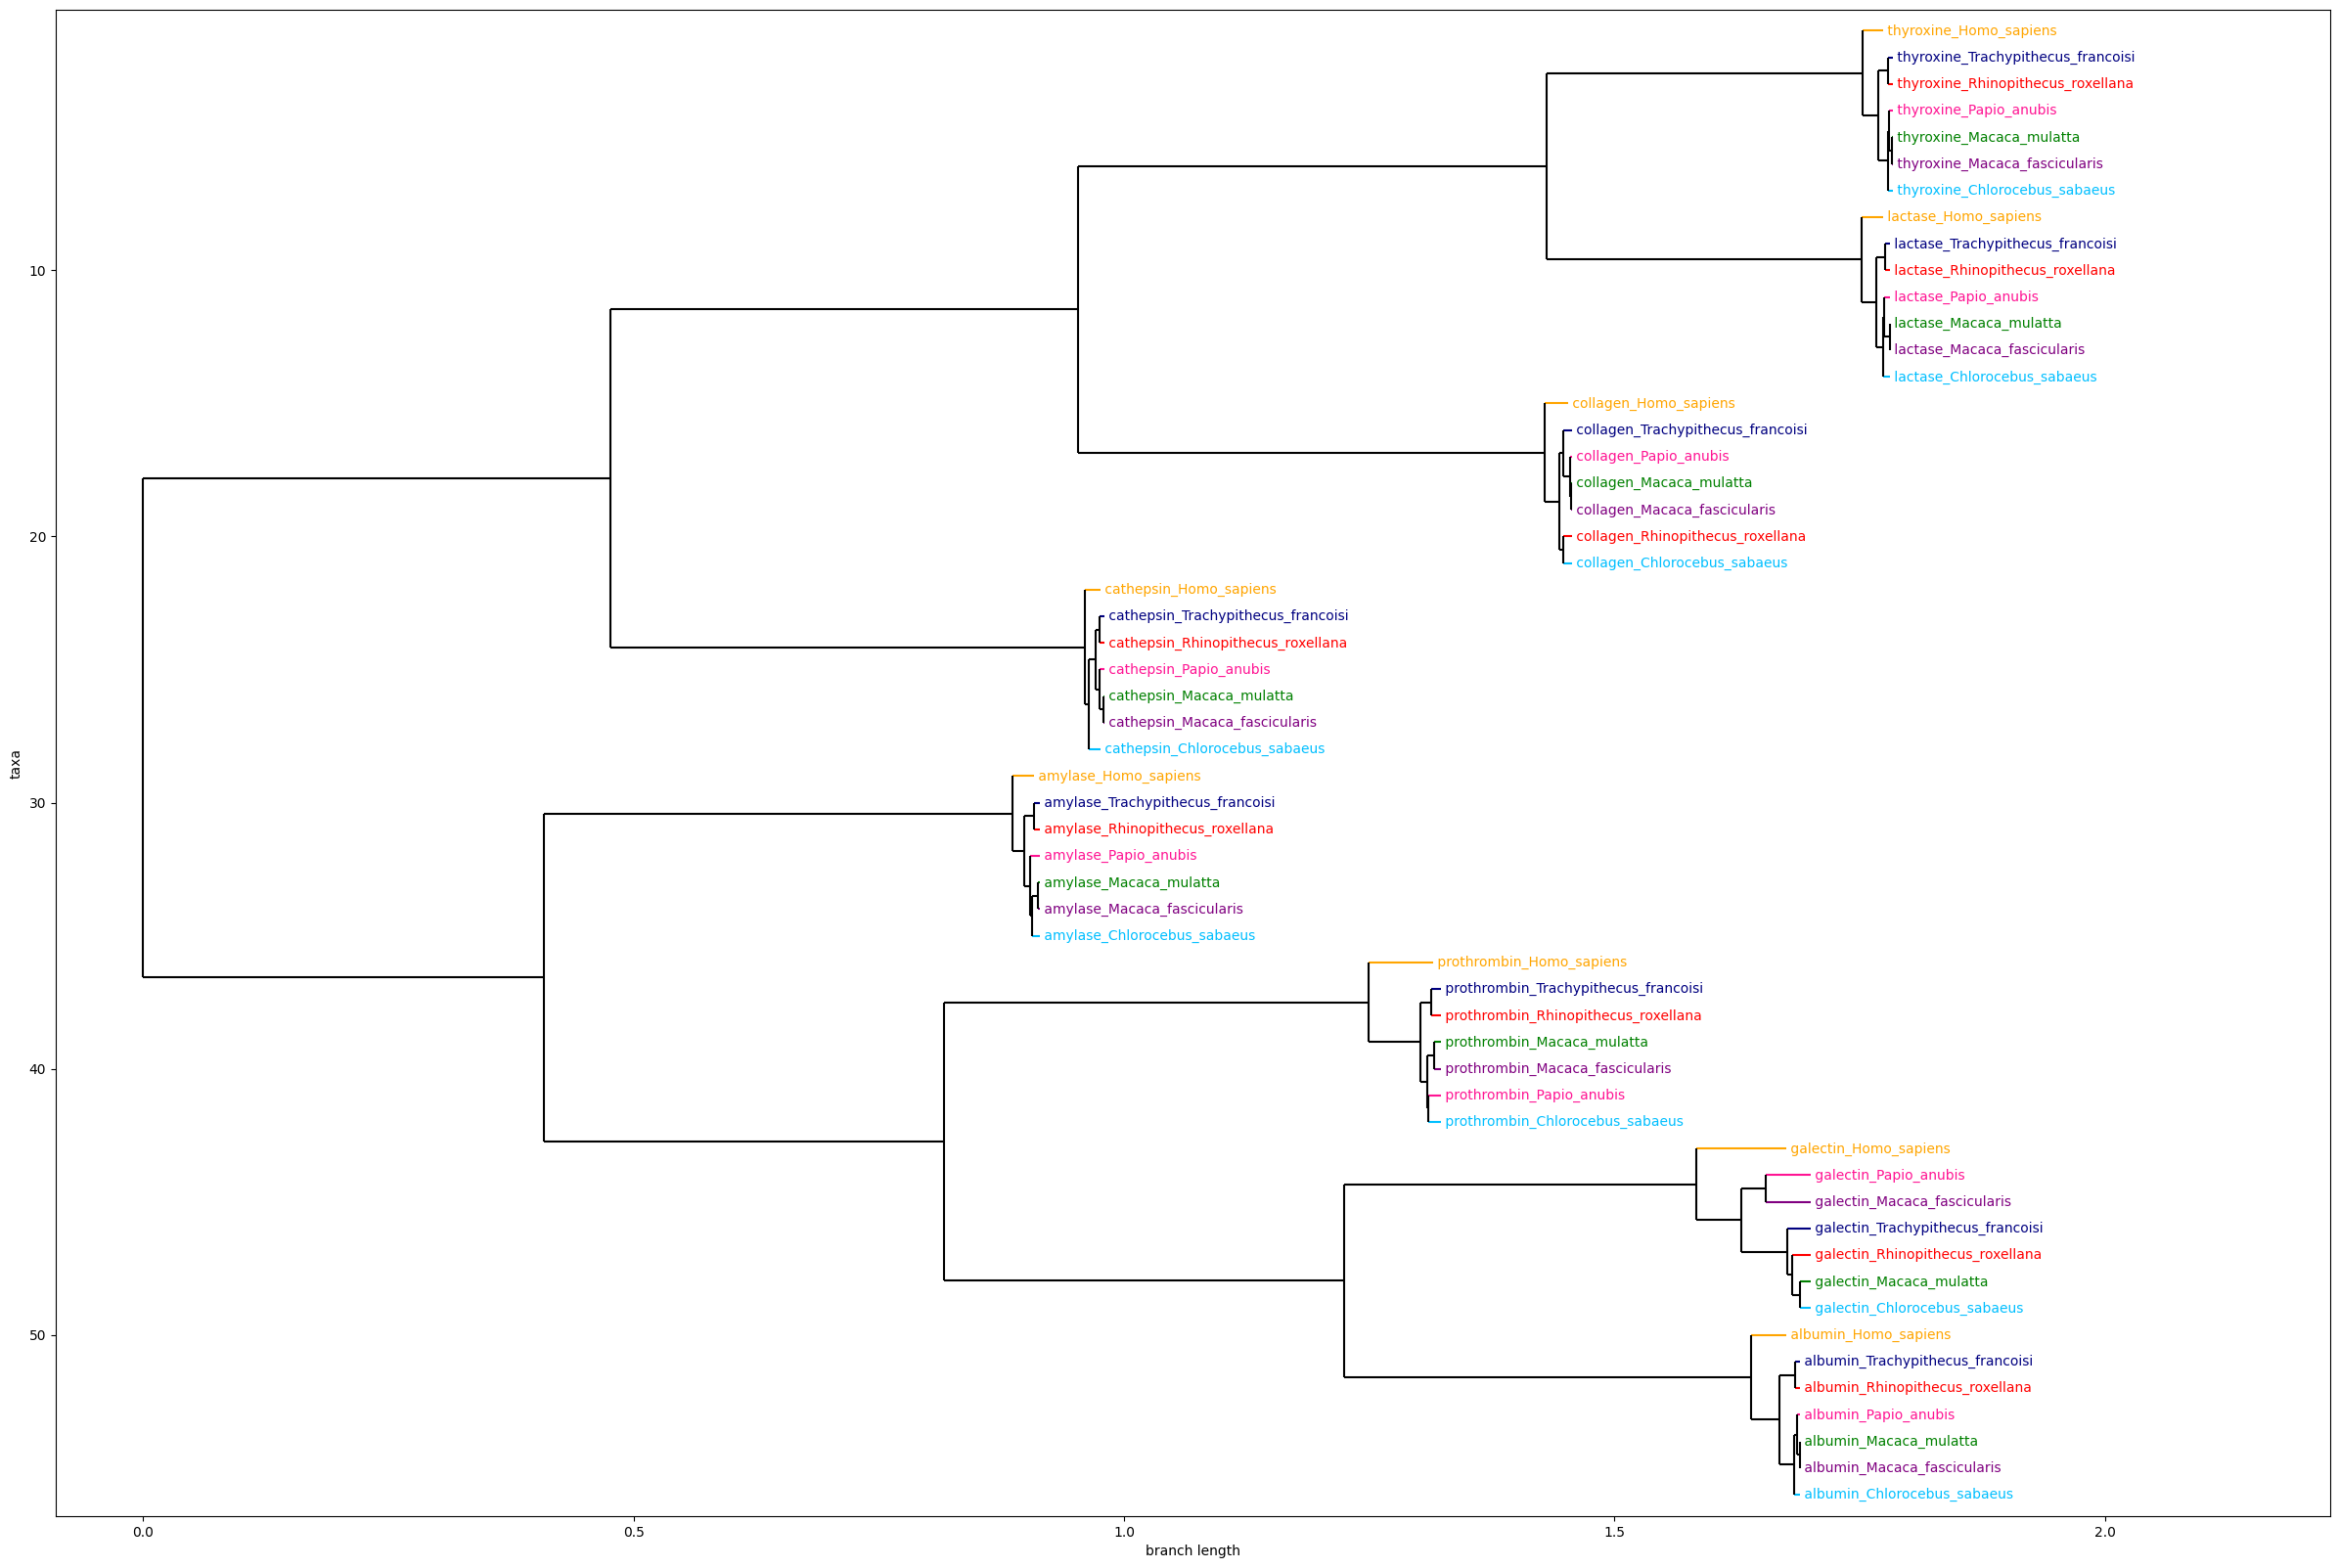

In [221]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(combined_tree, axes=ax, label_func=lambda x: x.name if x.is_terminal() else None, label_colors=label_colors)

### Common tree - organisms

In [222]:
label_colors = color_tree(combined_tree, protein_colors, org=False)

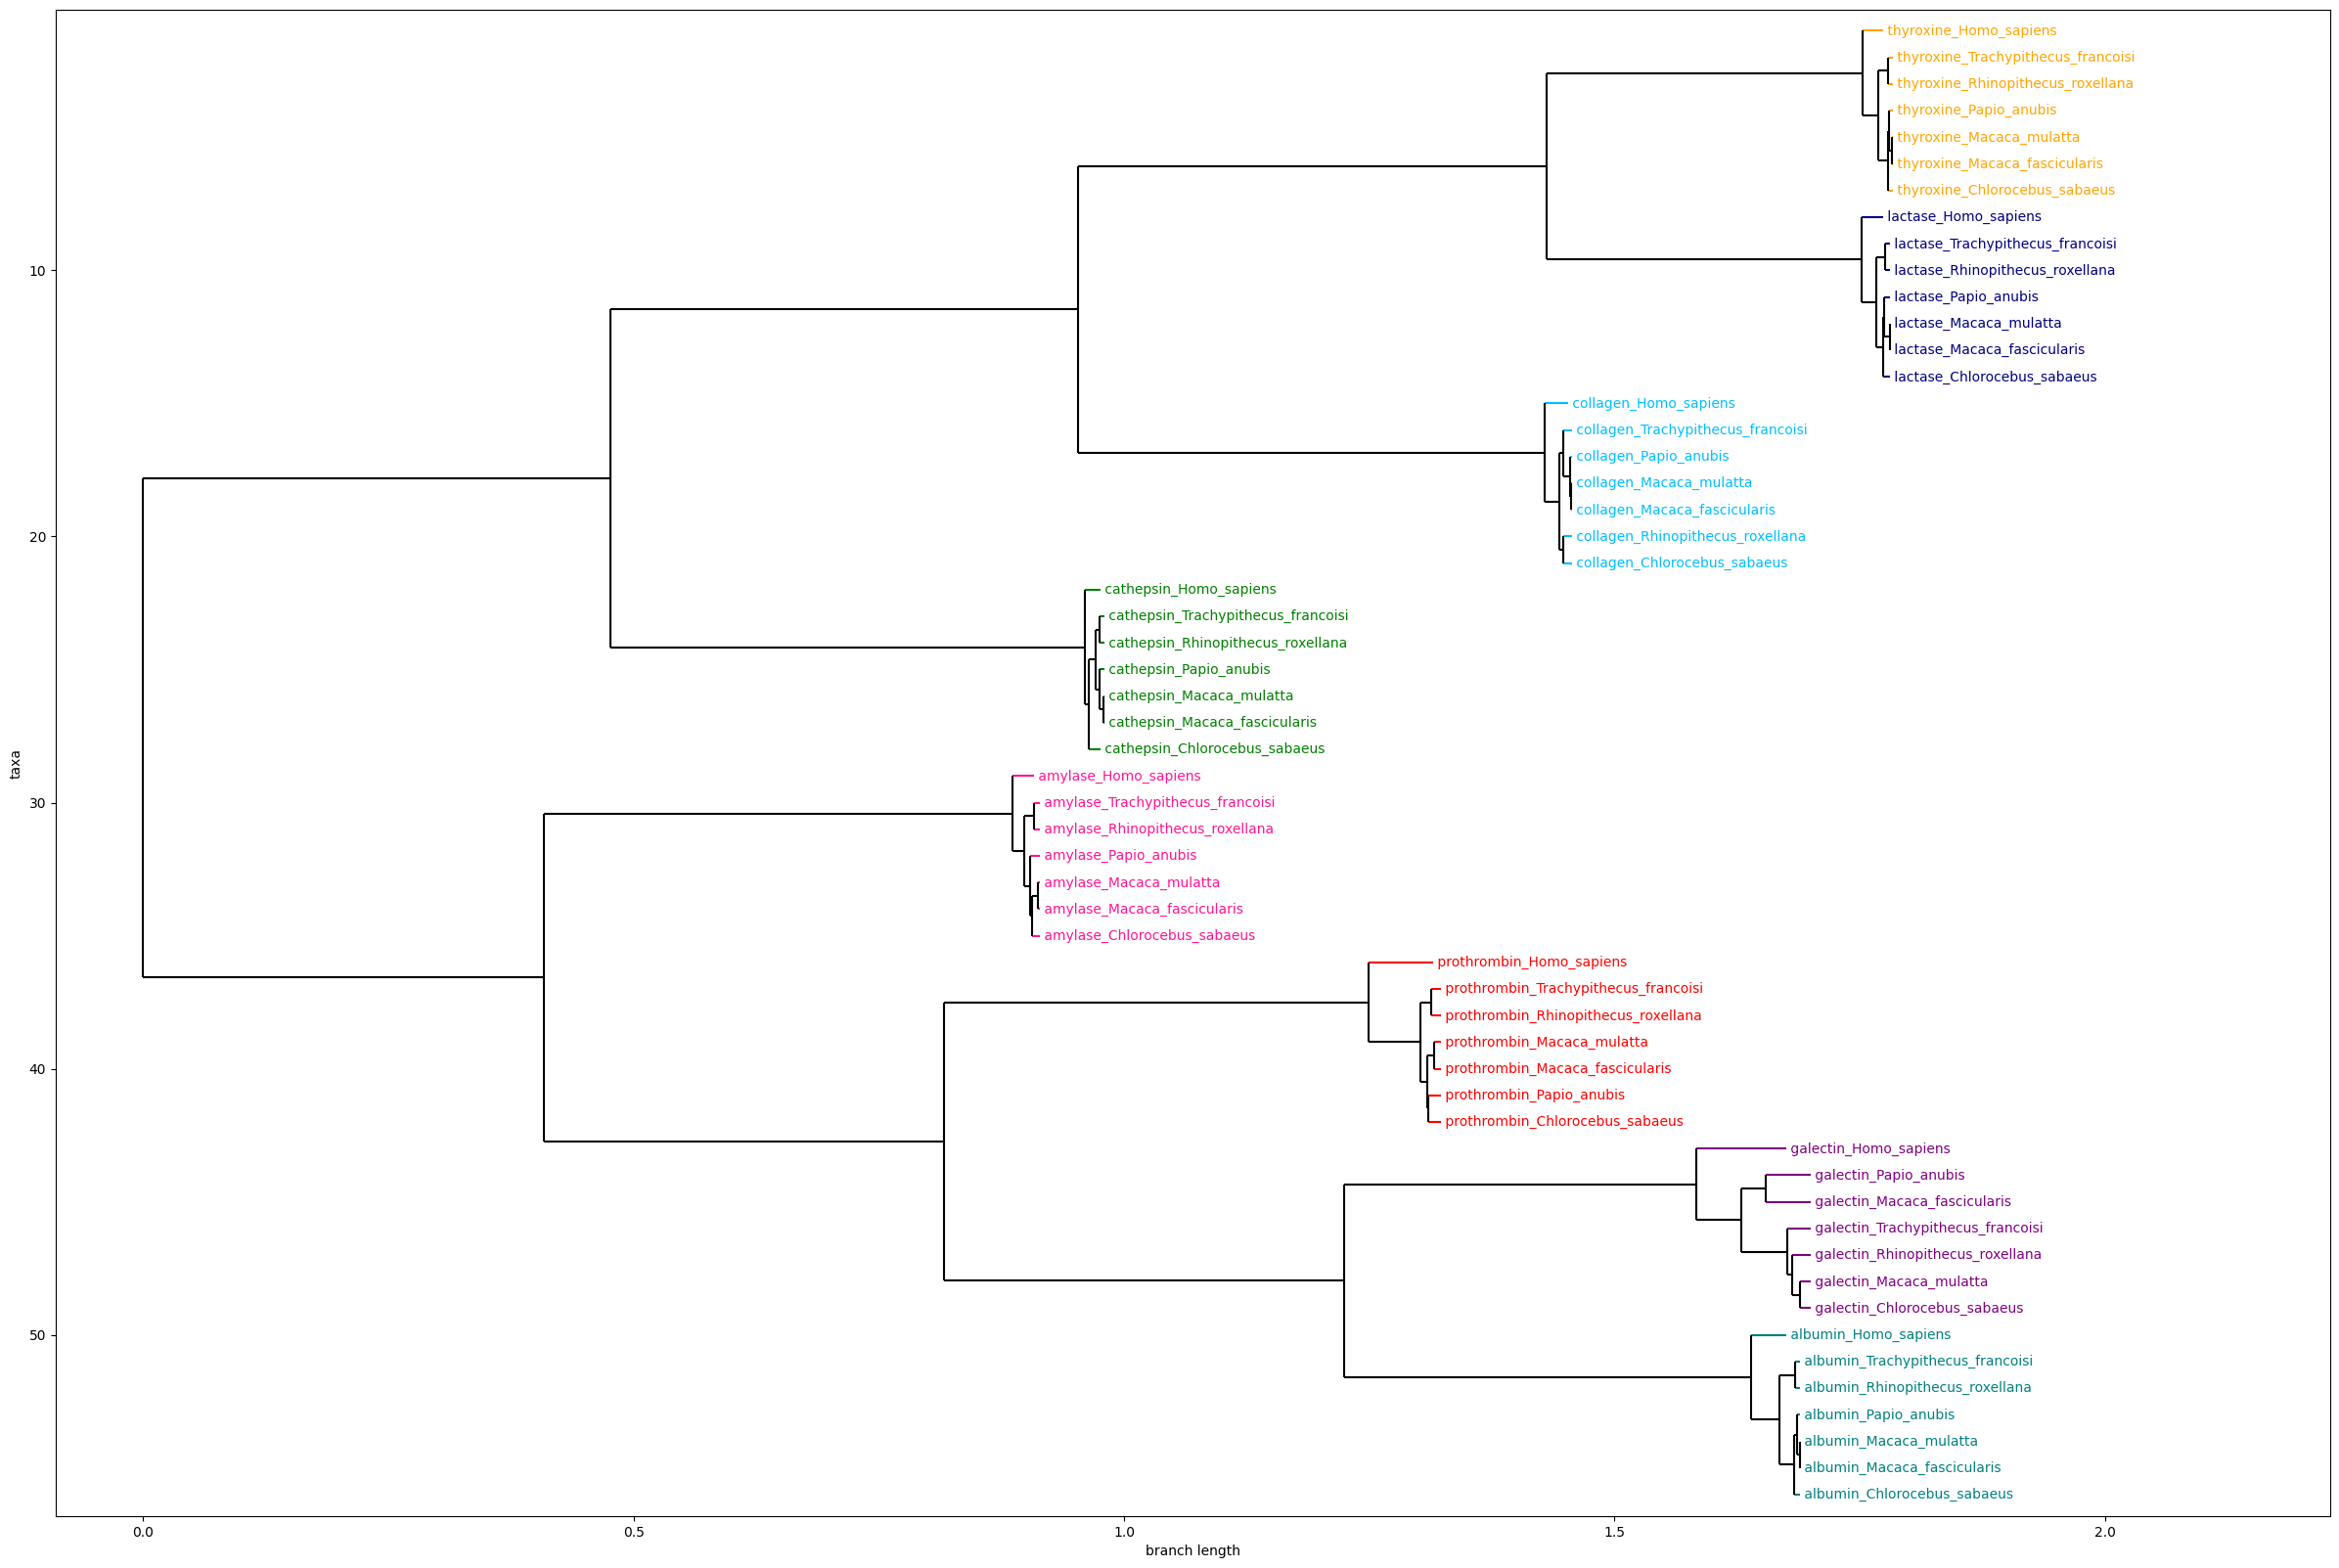

In [223]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(combined_tree, axes=ax, label_func=lambda x: x.name if x.is_terminal() else None, label_colors=label_colors)